In [2]:
import torch
from torch import cdist
import numpy as np
import pdb
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import norm
from scipy.stats import truncnorm
import time
from joblib import Parallel, delayed
import multiprocessing
from IPython.display import clear_output
from IPython.display import display
import sympy; sympy.init_printing()
%matplotlib inline

In [3]:
def display_matrix(m):
    display(sympy.Matrix(m))

In [4]:
## function to solve the schnakenberg system on a time grid
## for a given initial condition and parameter value

def schnaken_solve(t,w,init):
    """
    This function produces the state and sensitivity solution on a time grid t
    
    Arguments
    =========
    t: (array) time grid on which we want the solution
    w: (array) array containing parameter values
    init: (array) array containing initial conditions for a,b (note a,b>0 for all time)
    """
    
    # ensure parameters are >0 and initial conditions are >0
    if (init[0] <= 0 or init[1] <= 0):
        print('Please ensure initial conditions are positive')
        return ValueError
    
    # set up function for ODE as a system of coupled first order ODEs
    def f(y, t, params):
        a, b = y   # unpack current values of y
        w1, w2, w3, w4 = params   # unpack parameter values
        derivs = np.array([np.exp(w1)*(a**2)*b + np.exp(w2) - np.exp(w3)*a,
                 -np.exp(w1)*(a**2)*b + np.exp(w4)])
        return derivs
    
    # solve system of ODEs using odeint
    soln = odeint(f,init,t,args=(w,))
    
    # return solution
    return soln

In [5]:
## code to generate random initial conditions and solve system on a time grid t
def noisySchnaken(N,sigma_a,sigma_b,t,w,lower=0,upper=np.inf,mu_a=1,mu_b=1):
    """
    This function generates N sets of initial conditions and uses sens_solve code above to solve the system for these initial conditions.
    The initial conditions for a and b are drawn i.i.d from truncated normal distribution
    
    Arguments
    =========
    N: (int) number of random initial conditions to draw
    sigma_a: (float) standard deviation for truncated normal distribution for a
    sigma_b: (float) standard deviation for truncated normal distribution for b
    t: (array) time grid at which we want solution
    w: (array) array containing parameter values
    lower: (float) left truncation point for both a,b distn (set to 0 by default)
    upper: (float) right truncation point for both a,b distn (set to Inf by default)
    mu_a: (float) mean for truncated normal distribution for a (set to 1 by default)
    mu_b: (float) mean for truncated normal distribution for b (set to 1 by default)
    """
    
    # set up initial conditions
    init = np.zeros(N*2).reshape(N,-1)
    init[:,0] = truncnorm.rvs((lower-mu_a)/sigma_a,(upper-mu_a)/sigma_a,loc=mu_a,scale=sigma_a,size=N)  # initial condition for a
    init[:,1] = truncnorm.rvs((lower-mu_b)/sigma_b,(upper-mu_b)/sigma_b,loc=mu_b,scale=sigma_b,size=N)  # initial condition for b
    
    def solveSys(i):
        return schnaken_solve(t,w,init[i,:])
    
    num_cores = multiprocessing.cpu_count()
    
    results = Parallel(n_jobs=num_cores)(delayed(solveSys)(i) for i in range(N))
    
    # return results
    return results

In [6]:
## function to compute unbiased estimate of MMD (using Gaussian kernel)
## for sampled paths from above system and also return the gradient
## wrt the paths (using torch.autograd package).
def MMD_U(p,q,sigma, need_grad = True):
    """
    Evaluates an unbiased estimate of MMD
     
    Arguments
    ==========
    p, q: iid sampled paths from the two distributions in question
     
    sigma: (float) bandwith for Gaussian kernel
    
    need_grad: (logical) if true require grad, if not only compute mmd
    """
    
    # ensure p,q are tensors
    p = torch.from_numpy(p)
    q = torch.from_numpy(q)
    
    # if require gradient set up operation tracking
    if need_grad:
        p.requires_grad_(True)
        q.requires_grad_(True)
    
    # compute number of sampled paths for both distributions
    m = p.shape[0]
    n = q.shape[0]
    
    # compute all the distance matrices D_pp, D_qq, D_pq
    # (i.e. D_pp is matrix containing all distances between 
    # ll pairs of points in the samples from p, and D_pq contains
    # the distances between all pairs with one point from samples of p
    # and other from samples of q)
    D_pp = cdist(p,p)
    D_qq = cdist(q,q)
    D_pq = cdist(p,q)
    
    # evaluate the kernel function for all possible pairs (pp,qq,pq)
    K_pp = torch.exp(-sigma * (D_pp**2))
    K_qq = torch.exp(-sigma * (D_qq**2))
    K_pq = torch.exp(-sigma * (D_pq**2))
    
    # compute estimate and return
    est = (1/(m*(m-1)))*(K_pp.sum()-K_pp.trace())+(1/(n*(n-1)))*(K_qq.sum()-K_qq.trace())-(2/(m*n))*(K_pq.sum())
    
    # if require gradient compute it now and return MMD est and gradient (wrt p)
    if need_grad:
        est.backward()
        grad_mmd = p.grad
        grad_mmd = grad_mmd.flatten()
        grad_mmd = grad_mmd.reshape((2*m,int(p.shape[1]/2))).transpose(0,1)
        return np.asscalar(est.detach().numpy()), grad_mmd.detach().numpy()
    return np.asscalar(est.numpy())

In [7]:
def adjoint_solve(t,w,init):
    """
    Arguments
    =========
    t: (array) time grid on which we want the solution (should be interval given backwards)
    w: (array) array containing parameter values
    init: (array) array containing 'initial' conditions for a,b,lambda_1,lambda_2
    """
    
    # set up function for ODE as a system of coupled first order ODEs
    def f(y,t,params):
        a, b, lambda_1, lambda_2 = y   # unpack current values of y
        w1, w2, w3, w4 = params        # unpack parameter values
        derivs = np.array([np.exp(w1)*(a**2)*b + np.exp(w2) - np.exp(w3)*a,
                           -np.exp(w1)*(a**2)*b + np.exp(w4),
                           -(2*np.exp(w1)*a*b-np.exp(w3))*lambda_1 + 2*np.exp(w1)*a*b*lambda_2,
                           -np.exp(w1)*(a**2)*lambda_1 + np.exp(w1)*(a**2)*lambda_2])
        return derivs
    
    # solve system of ODEs using odeint
    soln = odeint(f,init,t,args=(w,))
    
    # return solution
    return soln

In [8]:
# function to get the adjoint vector
def get_adjoint(x,y,t,w,sigma,n_steps):
    """
    Arguments
    =========
    x: (array) array holding the simulated data set (each row is one sampled path)
    y: (array) array holding the observed data (each row is one sample)
    t: (array) array holding time points the data is observed at
    w: (array) array containing parameter values
    sigma: (float) bandwith of Gaussian kernel
    n_steps: (int) number of time steps to use in each interval when solving adjoint equation
    """
    
    # compute the number of observations in simulated data
    N = x.shape[0]
    
    # compute the number of observations in y
    m = y.shape[0]
    
    # compute number of time points
    n = t.shape[0]
    
    # initialize a n x (2*N) array to hold the state vector and adjoint vector at each time point
    # (rows correspond to time point)
    adjoint = np.zeros(shape=(n,2*N))
    
    # compute gradient of squared mmd wrt paths x
    grad = MMD_U(x,y,sigma)[1]
    
    # grad = np.zeros(shape=(n,N*2)) ## for testing where code is slow
    #pdb.set_trace()
    
    # solve adjoint system iteratively over each time interval
    for i in range(n-1,0,-1):
        # get correct time interval (starting from end and moving back)
        if (i != 1):
            t_grid = t[i:(i-2):-1]
        else:
            t_grid = t[0:2][::-1]
        
        # create time grid for this interval
        t_grid = np.linspace(t_grid[0],t_grid[1],n_steps)
        #pdb.set_trace()
        # set up 'initial' condition for this interval
        init = np.zeros(N*4).reshape(N,-1)
        if (i != (n-1)):
            grad_cost = grad[i,:]
            init[:,2] = grad_cost[0:(2*N):2] + adjoint[n-i-1,0:(2*N):2]
            init[:,3] = grad_cost[1:(2*N+1):2] + adjoint[n-i-1,1:(2*N+1):2]
        else:
            grad_cost = grad[i,:]
            init[:,2] = grad_cost[0:(2*N):2]
            init[:,3] = grad_cost[1:(2*N+1):2]
        init[:,0:2] = x[:,i:(2*n):n]
        
        # solve the N systems in parallel 
        def solveSys(j):
            soln = adjoint_solve(t_grid,w,init[j,:])
            return (soln[:,2:4])
        
        num_cores = multiprocessing.cpu_count()
    
        results = Parallel(n_jobs=num_cores)(delayed(solveSys)(j) for j in range(N))
        
        results = np.hstack(results)
        
        adjoint[n-i,:] = results[-1,:]
    
    return(adjoint)

In [9]:
# function to obtain gradient of lagrangian given the adjoint vector
def get_grad_lagrangian(adjoint,x,t,w):
    """
    Arguments
    =========
    adjoint: (array) array holding the adjoint vector lambda(t) at the time points in t
    x: (array) array holding the simulated data set (each row is one sampled path)
    t: (array) array holding time points the data is observed at
    w: (array) array containing parameter values
    """
    
    # compute number of simulated paths
    N = x.shape[0]
    
    # computer number of time points
    n = t.shape[0]
    
    # first rearrange adjoint array so that entries are in 'forward' time order
    adjoint = adjoint[::-1,:]
    
    # compute derivatives of Phi wrt parameters and store results in matrix
    # note: this is done in parallel for the N systems and the results are stacked vertically
    def f(x,w):
        x1, x2 = x
        w1, w2, w3, w4 = w
        deriv = np.array([[np.exp(w1)*(x1**2)*x2, np.exp(w2), -np.exp(w3)*x1, 0],
                         [-np.exp(w1)*(x1**2)*x2, 0, 0, np.exp(w4)]])
        return deriv
    
    num_cores = multiprocessing.cpu_count()
    
    jacobian = np.zeros(shape=(n-1,(2*N),4))
    for i in range(n-1):
        samples = x[:,i:(2*n+i):n]
        def compute_jacobian(j):
            return f(samples[j,:],w)
        
        results = Parallel(n_jobs=num_cores)(delayed(compute_jacobian)(j) for j in range(N))
        
        jacobian[i] = np.vstack(results)

    diff_time_grid = np.diff(t)
    
    grad = np.einsum('rs,rsq,r->q',adjoint[0:(n-1),:],jacobian,diff_time_grid)
    
    return grad
    

In [10]:
## for live updates in results
def live_plot(data,mmd,figsize=(12,7)):
    clear_output(wait=True)
    fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=figsize,constrained_layout=True)
    
    ax1.plot(data[:,0])
    ax1.grid()
    ax1.set_xlabel('iteration')
    ax1.set_ylabel(r'$\theta_1$')
    
    ax2.plot(data[:,1])
    ax2.grid()
    ax2.set_xlabel('iteration')
    ax2.set_ylabel(r'$\theta_2$')
    
    ax3.plot(data[:,2])
    ax3.grid()
    ax3.set_xlabel('iteration')
    ax3.set_ylabel(r'$\theta_3$')
    
    ax4.plot(data[:,3])
    ax4.grid()
    ax4.set_xlabel('iteration')
    ax4.set_ylabel(r'$\theta_4$')
    
    ax5.plot(mmd)
    ax5.grid()
    ax5.set_xlabel('iteration')
    ax5.set_ylabel('MMD')
    
    fig.delaxes(ax6)
    
    plt.show()

In [11]:
def adjoint_grad_descent(y,t,sigma_a,sigma_b,sigma,Lambda,w_init,n_sim,n_steps,step_size=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-8,N_iter=100,lower=0,upper=np.inf,mu_a=1,mu_b=1):
    """
    Arguments
    =========
    y: (array) array holding the observed data (each row one sample)
    t: (array) array holding time points the data is observed at
    sigma_a: (float) standard deviation for truncated normal distribution for a
    sigma_b: (float) standard deviation for truncated normal distribution for b
    sigma: (float) bandwidth of Gaussian kernel
    Lambda: (float) parameter controlling regularization (set to 0 if this is not needed)
    w_init: (array) parameter values to initialise gradient descent with
    n_sim: (int) number of samples to simulate at each step of gradient descent
    n_steps: (int) number of time divisions to use for each interval when solving adjoint system
    step_size: (float) step size for gradient descent (set to 0.01 by default)
    beta_1: (float) parameter needed in ADAM
    beta_2: (float) parameter needed in ADAM
    epsilon: (float) parameter needed in ADAM
    N_iter: (int) max number of steps to take in gradient descent algorithm
    lower: (float) left truncation point for both a,b distn (set to 0 by default)
    upper: (float) right truncation point for both a,b distn (set to Inf by default)
    mu_a: (float) mean for truncated normal distribution for a (set to 1 by default)
    mu_b: (float) mean for truncated normal distribution for b (set to 1 by default)
    """
    
    # compute the number of observations in y
    m = y.shape[0]
    
    # set up array to hold w values
    w_hat = np.zeros((N_iter+1)*4).reshape(N_iter+1,-1)
    
    # set up array to hold moment_1 vectors
    moment_1 = np.zeros((N_iter+1)*4).reshape(N_iter+1,-1)
    
    # set up array to hold moment_2 vectors
    moment_2 = np.zeros((N_iter+1)*4).reshape(N_iter+1,-1)
    
    # put first w value in
    w_hat[0,:] = w_init
    
    # set up array to hold value of unbiased est of MMD
    MMD_est = np.zeros(N_iter+1)
    
    #pdb.set_trace()
    # perform the gradient descent
    for j in range(N_iter):
        
        # simulate a data set using previous parameter value
        dat = noisySchnaken(n_sim,sigma_a,sigma_b,t,w_hat[j,:],lower=0,upper=np.inf,mu_a=1,mu_b=1)
        dat = np.stack(dat)
    
        # store (a(0),a(t_1),...,a(t_{N-1}),b(0),b(t_1),...,b(t_{N-1})) values in a
        # n_sim x (2len(t)) array
        x = dat[:,:,0]
        x = np.concatenate((x,dat[:,:,1]),axis=1)  # concatenate b-values to the right of the a-values
        
        # compute unbiased est of MMD for monitoring performance
        MMD_est[j] = MMD_U(y,x,sigma,need_grad=False)
        
        #######################################################
        live_plot(np.exp(w_hat[0:(j+1),:]),MMD_est[0:(j+1)])
        #######################################################
        
        ## use adjoint method to compute gradient of loss/cost (mmd^2)
        
        # first compute adjoint using function get_adjoint
        adjoint = get_adjoint(x,y,t,w_hat[j,:],sigma,n_steps)
        
        # compute gradient using adjoint
        grad = get_grad_lagrangian(adjoint,x,t,w_hat[j,:])
        
        # add penalty term
        grad = grad + 2*Lambda*(1/np.sqrt(j+1))*w_hat[j,:]
        
        # update first moment estimate
        moment_1[j+1,:] = beta_1*moment_1[j,:]+(1-beta_1)*grad
        
        # update second raw moment estimate
        moment_2[j+1,:] = beta_2*moment_2[j,:]+(1-beta_2)*(grad**2)
        
        # compute bias corrected first moment estimate
        m_hat = moment_1[j+1,:]/(1-(beta_1**(j+1)))
        
        # compute bias corrected second raw moment estimate
        v_hat = moment_2[j+1,:]/(1-(beta_2**(j+1)))
        
        ## perform the update
        w_hat[j+1,:] = w_hat[j,:] - (step_size*m_hat)/(np.sqrt(v_hat)+epsilon)

    # compute unbiased est of MMD for this final w val
    dat = noisySchnaken(n_sim,sigma_a,sigma_b,t,w_hat[-1,:],lower=0,upper=np.inf,mu_a=1,mu_b=1)
    dat = np.stack(dat)
    x = dat[:,:,0]
    x = np.concatenate((x,dat[:,:,1]),axis=1)
    MMD_est[-1] = MMD_U(y,x,sigma,need_grad=False)
    
    #######################################################
    live_plot(np.exp(w_hat[0:(j+2),:]),MMD_est[0:(j+2)])
    #######################################################
    
    # return w_hat, MMD_est
    return w_hat, MMD_est

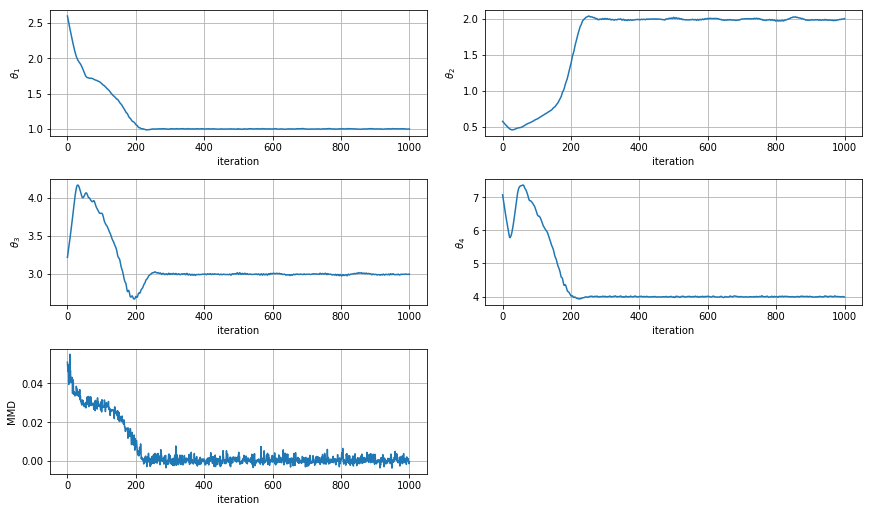

Time taken was: 2955.3247792720795
Bandwidth is: 2.4388171004632784
Initial parameter values are: [2.595 0.574 3.214 7.078]
Step size used is: 0.75
Min MMD obtained is: -0.004
Parameter vector which obtained this minimum is: [1.005 1.985 2.988 4.004]
True parameter vector is: [1 2 3 4]
Euclidean distance from true parameter vector is: 0.02


In [13]:
# Trial one
# generate a data set
start = time.time()
N = 1000
sigma_a = 0.5
sigma_b = 0.5
t = np.linspace(0,1,20)
theta = np.array([1,2,3,4])
w = np.log(theta)

# set seed
np.random.seed(seed=48514)

dat = noisySchnaken(N,sigma_a,sigma_b,t,w)
dat = np.stack(dat)
y = dat[:,:,0]
y = np.concatenate((y,dat[:,:,1]),axis=1)

# compute bandwidth to use
distMat = cdist(torch.from_numpy(y),torch.from_numpy(y))
distMat = 0.5*(distMat**2)
sigma = np.sqrt(np.median(distMat))

# perform gradient descent
w_init = np.array([0.9534900008539118,-0.555954628240538,1.167516807284435,1.957044540973418])

n_sim = 100
step = 0.75
n_iter = 1000
Lambda = 0
b_1 = 0.9
b_2 = 0.999
Eps = 1e-8
n_steps = 10

np.random.seed(seed=6)
w_hat,MMD_est = adjoint_grad_descent(y,t,sigma_a,sigma_b,sigma,Lambda,w_init,n_sim,n_steps,step_size=0.01,beta_1=b_1,beta_2=b_2,epsilon=Eps,N_iter=n_iter)
end = time.time()

print('Time taken was: %s'%(end-start))
print('Bandwidth is: %s' %(sigma))
print('Initial parameter values are: %s' %(np.around(np.exp(w_init),decimals=3)))
print('Step size used is: %s' %(step))

print('Min MMD obtained is: %s'%(np.around(MMD_est.min(),decimals=3)))
print('Parameter vector which obtained this minimum is: %s'%(np.around(np.exp(w_hat[MMD_est.argmin(),:]),decimals=3)))
print('True parameter vector is: %s' %(theta))
print('Euclidean distance from true parameter vector is: %s' %(np.around(np.linalg.norm(np.exp(w_hat[MMD_est.argmin(),:])-theta),decimals=3)))

In [14]:
## code to save results
# np.save('w_hat_exp_1.npy',w_hat)
# np.save('MMD_est_exp_1.npy',MMD_est)

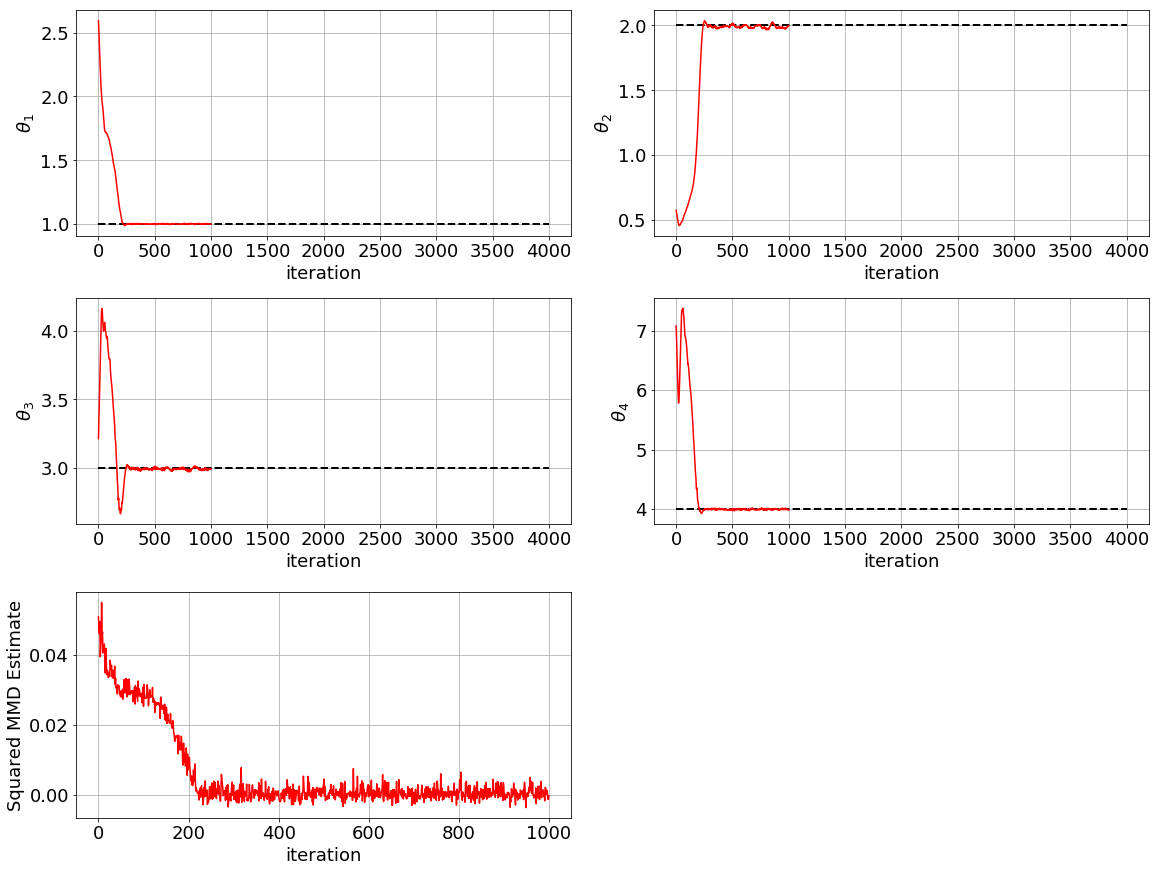

In [28]:
# code to plot results
plt.rcParams.update({'font.size': 18})
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(16,12),constrained_layout=True)

ax1.plot(np.exp(w_hat[:,0]),color='r')
ax1.hlines(1,0,4000,linestyle='dashed',lw=2)
ax1.set_xlabel('iteration')
ax1.set_ylabel(r'$\theta_1$')
ax1.grid()

ax2.plot(np.exp(w_hat[:,1]),color='r')
ax2.hlines(2,0,4000,linestyle='dashed',lw=2)
ax2.set_xlabel('iteration')
ax2.set_ylabel(r'$\theta_2$')
ax2.grid()

ax3.plot(np.exp(w_hat[:,2]),color='r')
ax3.hlines(3,0,4000,linestyle='dashed',lw=2)
ax3.set_xlabel('iteration')
ax3.set_ylabel(r'$\theta_3$')
ax3.grid()

ax4.plot(np.exp(w_hat[:,3]),color='r')
ax4.hlines(4,0,4000,linestyle='dashed',lw=2)
ax4.set_xlabel('iteration')
ax4.set_ylabel(r'$\theta_4$')
ax4.grid()

ax5.plot(MMD_est,color='r')
ax5.set_xlabel('iteration')
ax5.set_ylabel('Squared MMD Estimate')
ax5.grid()

fig.delaxes(ax6)

plt.show()
fig.savefig('results_2.png', bbox_inches='tight',dpi=300)

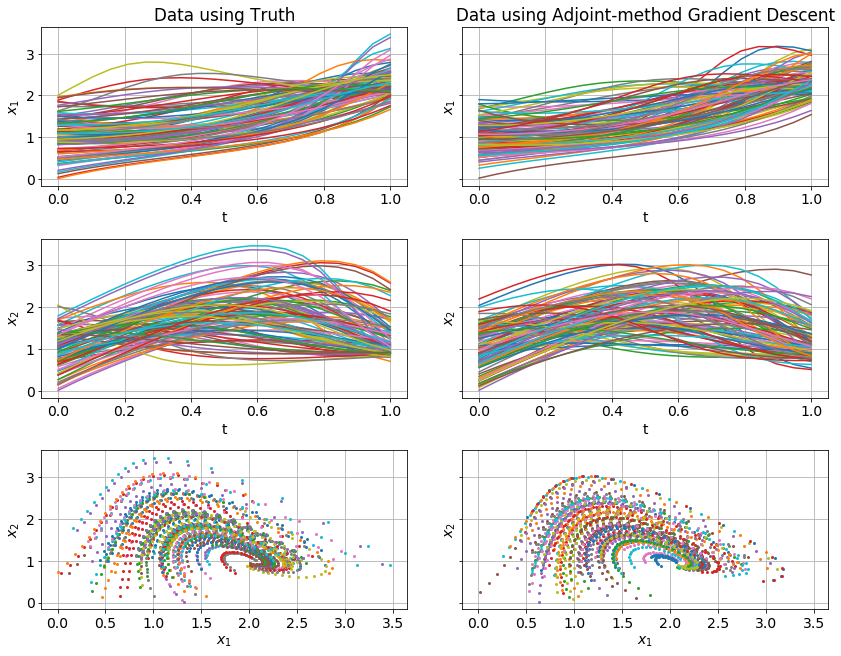

In [22]:
# code to plot samples from true vector and vector obtained from algorithm
w_true = np.log(theta)
sigma_a = 0.5
sigma_b = 0.5
t = np.linspace(0,1,20)

# plot solutions with these parameter vals
N_sols = 100
w_res = w_hat[MMD_est.argmin(),:]
np.random.seed(seed=8748641)
soln_res = noisySchnaken(N_sols,sigma_a,sigma_b,t,w_res)
soln_res = np.stack(soln_res)
soln_true = noisySchnaken(N_sols,sigma_a,sigma_b,t,w_true)
soln_true = np.stack(soln_true)

plt.rcParams.update({'font.size': 14})
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(12,9),constrained_layout=True,sharey='row',sharex='row')
for i in range(N_sols):
    ax1.plot(t,soln_true[i,:,0])
    ax2.plot(t,soln_res[i,:,0])
    ax3.plot(t,soln_true[i,:,1])
    ax4.plot(t,soln_res[i,:,1])
    ax5.plot(soln_true[i,:,0],soln_true[i,:,1],'o',ms=2)
    ax6.plot(soln_res[i,:,0],soln_res[i,:,1],'o',ms=2)
ax1.set_xlabel('t')
ax2.set_xlabel('t')
ax3.set_xlabel('t')
ax4.set_xlabel('t')
ax5.set_xlabel(r'$x_1$')
ax6.set_xlabel(r'$x_1$')

ax1.set_ylabel(r'$x_1$')
ax2.set_ylabel(r'$x_1$')
ax3.set_ylabel(r'$x_2$')
ax4.set_ylabel(r'$x_2$')
ax5.set_ylabel(r'$x_2$')
ax6.set_ylabel(r'$x_2$')

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

ax1.set_title('Data using Truth')
ax2.set_title('Data using Adjoint-method Gradient Descent')
plt.show()
fig.savefig('results_2_data_gen.png', bbox_inches='tight',dpi=300)